# Imports


In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization

# from sklearn.model_selection import GroupShuffleSplit
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import seaborn as sn

# Load Data


In [2]:
path = "/content/drive/MyDrive/Thesis/Datasets/Turbofan_Dataset/final_datasets_normalized/"

In [3]:
# Load data and drop irrelevant columns

df_train = pd.read_csv(path + "TRAINING_SET_FULL.csv")
df_test = pd.read_csv(path + "TEST_SET_FULL.csv")

drop_cols = ["cycle","setting3","s1","s5","s10","s16","s18","s19","RUL"]
corr_cols = ["s11","s4","s15","s17","s2","s3","s8","s13","s9","s14","s12","s7","s20"]
feature_cols = ['cycle_norm', 'setting1', 'setting2', 's2', 's3', 's4', 's6', 's7',
       's8', 's9', 's11', 's12', 's13', 's14', 's15', 's17', 's20', 's21']
prediction_col = 'fail_30'

train_set = df_train.drop(drop_cols, axis=1)
test_set = df_test.drop(drop_cols, axis=1)

In [4]:
# Move cycle_norm column first for convenience

column_to_move = train_set.pop("cycle_norm")
train_set.insert(0, "cycle_norm", column_to_move)

column_to_move = test_set.pop("cycle_norm")
test_set.insert(0, "cycle_norm", column_to_move)

In [5]:
# Shuffle rows
train_set = train_set.sample(frac=1)

In [6]:
# Use 80% for training and 20% for validation

valid_split = round(train_set.shape[0] * 0.8)
valid_split

16505

In [7]:
X_train = train_set.iloc[:valid_split, 0:-1].to_numpy()
y_train = train_set.iloc[:valid_split, -1].to_numpy()

X_valid = train_set.iloc[valid_split:, 0:-1].to_numpy()
y_valid = train_set.iloc[valid_split:, -1].to_numpy()

X_test = test_set.iloc[:, 0:-1].to_numpy()
y_test = test_set.iloc[:, -1].to_numpy()

# Define Model

In [8]:
# Defining LSTM model

model = Sequential()
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dense(64, activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.1))
model.add(Dense(1, activation='sigmoid'))


# Training

In [9]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics='binary_accuracy')  # the model is recompiled to reset the optimizer
# model.load_weights('simple_lstm_weights.h5')  # weights are reloaded to ensure reproducible results

history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    epochs=25,
                   batch_size=32)

Epoch 1/25
516/516 [==============================] - 6s 7ms/step - loss: 0.2355 - binary_accuracy: 0.9145 - val_loss: 0.2102 - val_binary_accuracy: 0.9300
Epoch 2/25
516/516 [==============================] - 3s 5ms/step - loss: 0.1307 - binary_accuracy: 0.9473 - val_loss: 0.1292 - val_binary_accuracy: 0.9462
Epoch 3/25
516/516 [==============================] - 3s 6ms/step - loss: 0.1322 - binary_accuracy: 0.9458 - val_loss: 0.1102 - val_binary_accuracy: 0.9547
Epoch 4/25
516/516 [==============================] - 4s 8ms/step - loss: 0.1246 - binary_accuracy: 0.9494 - val_loss: 0.2559 - val_binary_accuracy: 0.9084
Epoch 5/25
516/516 [==============================] - 4s 7ms/step - loss: 0.1243 - binary_accuracy: 0.9498 - val_loss: 0.1302 - val_binary_accuracy: 0.9430
Epoch 6/25
516/516 [==============================] - 4s 7ms/step - loss: 0.1184 - binary_accuracy: 0.9509 - val_loss: 0.1078 - val_binary_accuracy: 0.9547
Epoch 7/25
516/516 [==============================] - 4s 7ms/ste

# Evaluation


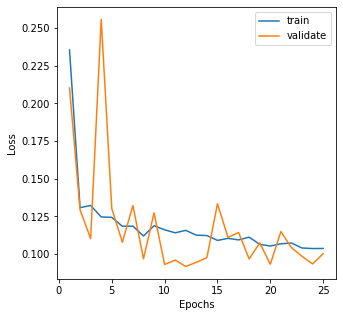

In [10]:
def plot_loss(fit_history):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(fit_history.history['loss'])+1), fit_history.history['loss'], label='train')
    plt.plot(range(1, len(fit_history.history['val_loss'])+1), fit_history.history['val_loss'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(history)

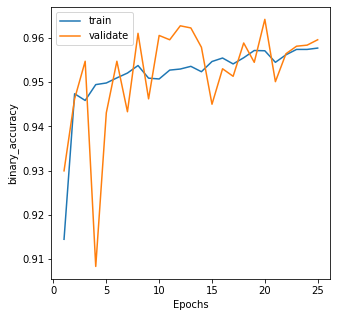

In [11]:
def plot_binary_accuracy(fit_history):
    plt.figure(figsize=(5,5))
    plt.plot(range(1, len(fit_history.history['binary_accuracy'])+1), fit_history.history['binary_accuracy'], label='train')
    plt.plot(range(1, len(fit_history.history['val_binary_accuracy'])+1), fit_history.history['val_binary_accuracy'], label='validate')
    plt.xlabel('Epochs')
    plt.ylabel('binary_accuracy')
    plt.legend()
    plt.show()

plot_binary_accuracy(history)

In [12]:
target_names = ['healthy', 'worn_out']

In [13]:
# Initial
# Train Score
y_hat_train = model.predict(X_train)
y_hat_int_train = y_hat_train.reshape(y_hat_train.shape[0]).round().astype(int)
label_array = y_train.reshape(y_train.shape[0]).astype(int)

print(classification_report(y_hat_int_train, y_train, target_names=target_names))

              precision    recall  f1-score   support

     healthy       0.97      0.98      0.98     13920
    worn_out       0.89      0.85      0.87      2585

    accuracy                           0.96     16505
   macro avg       0.93      0.92      0.92     16505
weighted avg       0.96      0.96      0.96     16505



In [14]:
# Initial
# Test set score

y_hat_test = model.predict(X_test)
y_hat_int_test = y_hat_test.reshape(y_hat_test.shape[0]).round().astype(int)
test_label_int = y_test.astype(int)

print(classification_report(y_hat_int_test, test_label_int, target_names=target_names))

              precision    recall  f1-score   support

     healthy       0.99      0.99      0.99     12753
    worn_out       0.69      0.67      0.68       343

    accuracy                           0.98     13096
   macro avg       0.84      0.83      0.84     13096
weighted avg       0.98      0.98      0.98     13096



In [15]:
mtx = confusion_matrix(test_label_int, y_hat_int_test)
mtx_norm = confusion_matrix(test_label_int, y_hat_int_test, normalize='true')

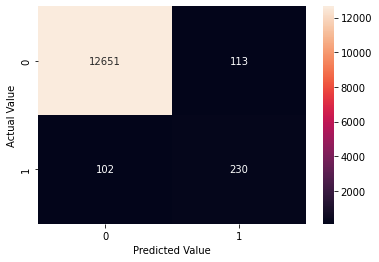

In [16]:
hm = sn.heatmap(mtx, annot=True, fmt='g')
hm.set(xlabel='Predicted Value', ylabel='Actual Value')
hm

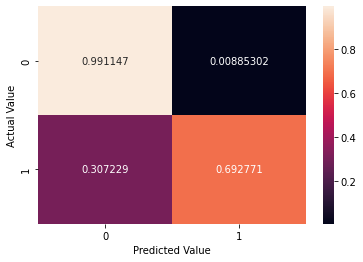

In [17]:
hm_norm = sn.heatmap(mtx_norm, annot=True, fmt='g')
hm_norm.set(xlabel='Predicted Value', ylabel='Actual Value')
hm_norm